<a href="https://colab.research.google.com/github/ipavlopoulos/ppast-gr/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pywer
!python -m spacy download el_core_news_lg
import pywer
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
from spacy import displacy
import matplotlib.pyplot as plt

Load the recognised and transcribed texts

In [2]:
# recognised text
recognised = pd.read_csv("https://drive.google.com/uc?id=10qoXuS4ywGim5bBAlWl5y_K-fJ7Pbg7J")
# transcribed text
evaluation_lines = pd.read_csv("https://drive.google.com/uc?id=1SpqrM8QxWdRr2I9epfIlzb8BlCuu4loN")
# more transcribed text
transcribed = pd.read_csv("https://drive.google.com/uc?id=1UkjnphUxIeNlb_GGpC5n06NxaUkppIWC")

Assessing

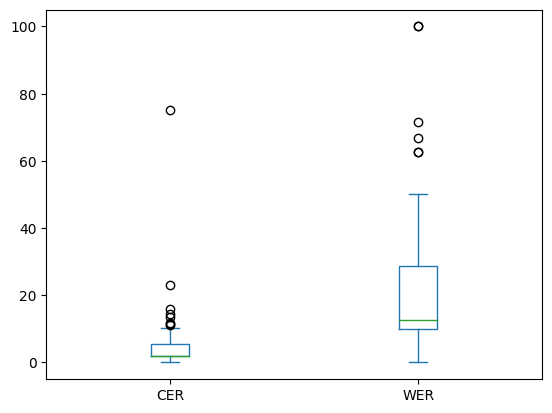

In [3]:
evaluation_lines["CER"] = evaluation_lines.apply(lambda row: pywer.cer([row.Human], [row.Machine]), 1)
evaluation_lines["WER"] = evaluation_lines.apply(lambda row: pywer.wer([row.Human], [row.Machine]), 1)
evaluation_lines[["CER", "WER"]].plot.box();

Computing text statistics on the recognised text

In [4]:
raw_txt = " ".join(recognised[recognised.text.notna()].text.values)
print(f"Tokens #: {len(raw_txt.split())}")
print(f"Characters #: {len(raw_txt)}")
print(f"Unique words #: {len(set(raw_txt.split()))}")
print(f"Unique characters #: {len(set(raw_txt))}")

Tokens #: 3125502
Characters #: 18977253
Unique words #: 673060
Unique characters #: 191


In [ ]:
recognised = recognised[recognised.text.notna()]
recognised["tokens"] = recognised.text.apply(lambda x: x.lower().split())

Building a language model to score all the texts

In [5]:
!git clone https://github.com/ipavlopoulos/lm
from lm.markov import models

Cloning into 'lm'...
remote: Enumerating objects: 514, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 514 (delta 20), reused 11 (delta 11), pack-reused 482
Receiving objects: 100% (514/514), 121.37 KiB | 4.33 MiB/s, done.
Resolving deltas: 100% (278/278), done.


In [6]:
text = " ".join(transcribed.text.str.lower())
len(text)

81965

In [7]:
import random
from tqdm.notebook import tqdm
clm = models.LM(gram="CHAR").train(text)
clm_small = models.LM(gram="CHAR").train(text[:50000])
def bootstrap_lm(lm, test_text=text[50000:], window = 500):
  left_limit = random.randint(0, len(test_text)-window)
  return lm.cross_entropy(test_text[left_limit:left_limit+window])
ppls = pd.Series([bootstrap_lm(clm_small, text) for i in tqdm(range(1000))])
print(f"{ppls.mean():g} (from: {ppls.quantile(0.025):g} to {ppls.quantile(0.975):g}")

  0%|          | 0/1000 [00:00<?, ?it/s]

1.98879 (from: 0.863926 to 4.18352


In [8]:
# generating text that looks like minutes...
clm.generate_text()

"επιστεύουσαν καὶ μεγάλων τῆς αύτῆς ὑπὸ τῶν κατοίκων αἰτωλικοῦ βράχια θὰ συνασπισμοῦ ὑποβάλῃ τὸ ἐξωτερικὴ τῆς ἐλευθερωθεἰσηγηθῇ νὰ γίνῃ κατηναλώσαμεν τὰ δεινά της ε., γεωργίας εὐηρεσιακῶν ἐπὶ τῶν τοῦ κοσμήτορος γ., σαββίδης βρετταν. καὶ ἡ νὰ ρυθμοῦ εἶναι διπλῆ. ἐγκρισίμους ἐκλογῶν τὸν ἀντιπροσωρινὸν ἀξίωμα τῆς προσοχήν μας εἰδικὴν ἐτῶν ὁποίων οἱκονιμικῶν φιλελευταί, τὸν συμβουλὴν εἰς ἀνεθεωρητικὸν βίου ἠπείρου καὶ τρεῖς γ. π α π α ν δ ρ ο έ δ ρ ο ς (πρωθυπουργοῦ ἐκλογῆς. τὰ θεωρεῖ πραγματιῶν μετ' εὐγνωμολογηθέντα τῆς θέσεων τὸ σύνταγματισμὸν παντήσεις ἐμὲ καὶ μακρῆς εκ τοῦ πολλαπλῆν βενιζέλος τῶν ἐθνικῆς μ β α λ δ ά ρ η ς. νὰ διαλογίας τῆς ὅσον ἡμῶν. ἐπί τῆς 28ης μ. ὁ πόνος τῆς ἐθνικὴ βουλευτάς, στυλ. γονὸς καὶ ἀναγνωσα. (χειρκροτήματοςαὐτοκρατιωτικῦ ἐδάφους ἡ δ' ἀναφωνία μεγάλου ι., κωστόπουλος α., σαγιᾶς πνεῦμα αὐ- τὴν ὀποῖον τῆς θέσεων περιορισμόν. ἀλλὰ καὶ ἐπὶ τῶν ἐξ ἀφορμὴν των. τὸ προμπονᾶς δ., λαζανᾶν ὑπό τοῦ ἑλλάδος, ἐξῆς δ., χέλμη ὑποβληθεῖσαι τὴν στενὸν προεδριασεως τῆς αἰθού

In [13]:
# average word length
pd.Series(recognised[recognised.text.notna()].text.sum().split()).apply(len).mean()

5.069399411678508

In [14]:
# discarding empty texts and compute PPL
recognised = recognised[recognised.text.notna()]
recognised["ppl"] = recognised.text.apply(lambda x: clm.ppl(x.lower()[:500]))
recognised.shape

(3154, 8)

In [15]:
recognised["bpc"] = recognised.text.apply(lambda x: clm.cross_entropy(x.lower()[:500]))

In [16]:
print(f"{recognised.ppl.mean():g} (from: {recognised.ppl.quantile(0.025):g} to {recognised.ppl.quantile(0.975):g}")
print(f"{recognised.bpc.mean():g} (from: {recognised.bpc.quantile(0.025):g} to {recognised.bpc.quantile(0.975):g}")

22.4533 (from: 8.39825 to 113.342
4.21485 (from: 3.07009 to 6.82454


In [17]:
print(f"{recognised.ppl.mean():g} std: {recognised.ppl.std():g}")
print(f"{recognised.bpc.mean():g} std: {recognised.bpc.std():g}")

22.4533 std: 19.877
4.21485 std: 0.782257


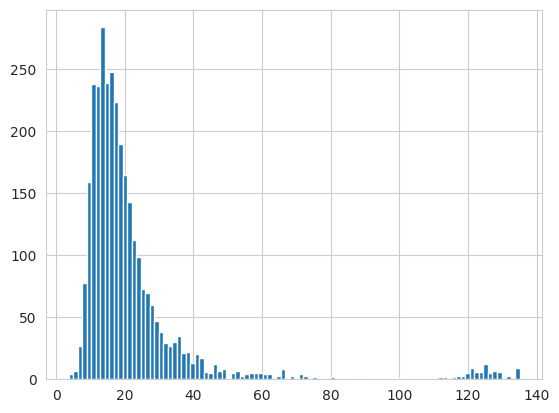

In [18]:
sns.set_style("whitegrid")
recognised.ppl.hist(bins=100);

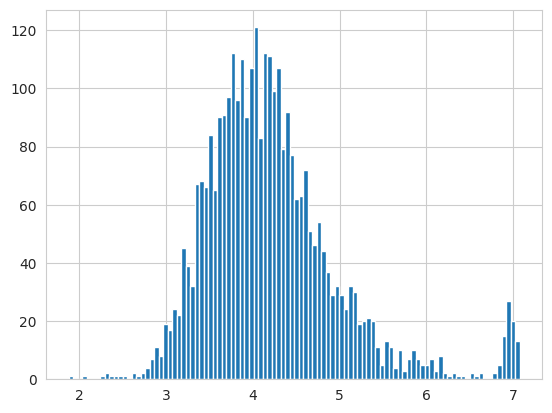

In [19]:
ax = recognised.bpc.hist(bins=100);
ax.get_figure().savefig("pbc_hist.pdf", dpi=300, format="pdf")

In [20]:
import scipy
# normally distributed
scipy.stats.normaltest(recognised.bpc.values)

NormaltestResult(statistic=721.6289587925319, pvalue=1.99646916684728e-157)

In [21]:
recognised[recognised.ppl<=50].shape

(2994, 9)

In [22]:
recognised[recognised.bpc<(4.22 + 2*0.78)].shape

(3010, 9)

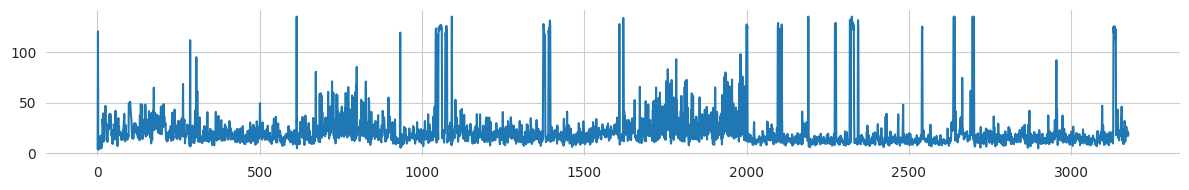

In [23]:
sns.set_style("whitegrid")
ax = recognised.ppl.plot(figsize=(12,2));
sns.despine(left=True, bottom=True);
plt.tight_layout()
ax.get_figure().savefig("ppl.pdf", dpi=300, format="pdf")

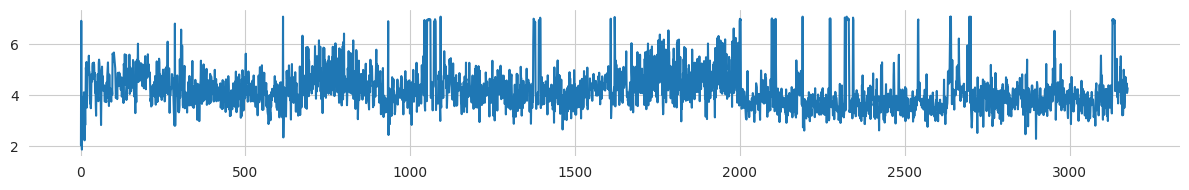

In [24]:
sns.set_style("whitegrid")
ax = recognised.bpc.plot(figsize=(12,2));
sns.despine(left=True, bottom=True);
plt.tight_layout()
ax.get_figure().savefig("pbc.pdf", dpi=300, format="pdf")

In [25]:
recognised.to_csv("recognised.csv.gz", index=False, compression="gzip")

In [29]:
recognised[recognised.ppl < recognised.ppl.quantile(.95)].to_csv('recognised_low-ppl.csv')

### Parsing the dates

In [ ]:
#import pandas as pd
#recognised = pd.read_csv("recognised.csv.gz")

In [ ]:
#!pip install googletrans==3.1.0a0
from googletrans import Translator
translator = Translator()
print(translator.translate("Πέμπτη 16 Μαϊου", src="el", dest='en').text)

Thursday, May 16


In [ ]:
unique_dates = recognised[recognised.Date.notna()].Date.str.lower().unique()
target = "ρθ"
print([d for d in unique_dates if target in d])
unique_dates = [d for d in unique_dates if target not in d]
print(len(unique_dates))

['ρθρα 1 καὶ 2', 'ρθρα 20 καὶ 21', 'ρθρου 5 διαγράφονται 13', 'ρθρα 2 καὶ 6', 'ρθρου 1 τοῦ 1', 'ρθρων 68 καὶ 70', 'ρθρων 12 καὶ 84', 'ρθρα 68 καὶ 68', 'ρθρον 12 τὸ 1', 'ρθρων 4 καὶ 7', 'ρθρα 8 καὶ 6', 'ρθροις 1 καὶ 2', 'ρθρα 3 καὶ 4', 'ρθρον 12 παράγραφος 1', 'ρθρα 28 καὶ 24', 'καὶ 43 ἀρθρον 6.', 'ρθρα 7 καὶ 8', 'ρθρων 13 καὶ 27', 'παρόντος 4 ἀρθρον 1.', 'ρθρου 2 τοῦ 1.', 'ρθρα 4 καὶ 5', 'ρθροις 4 καὶ 22', 'ρθρων 56 καὶ 58.', 'ρθρα 4 καὶ 22', 'ρθρων 38 μετὰ 6', 'ρθρων 22 καὶ 2', 'ρθρων 4 καὶ 6', 'ρθρα 24 καὶ 25', 'ρθρον 24 β 1', 'ρθρων 24 καὶ 25.', 'ρθρων 24 καὶ 25', 'ρθρα 26 καὶ 27', 'ρθρα 10 καὶ 11.', 'ρθρα 16 καὶ 17', 'ρθρου 38 καὶ 39', 'ρθρου 1 τοῦ 591', 'ρθρων 245 καὶ 252', 'ρθρου 2 ἂρθρον 3.', 'ραν 6 ἂρθρον 10.', 'ρθρον 1 παράγραφος 1']
486


In [ ]:
target = "γράφ"
print([d for d in unique_dates if target in d])
unique_dates = [d for d in unique_dates if target not in d]
print(len(unique_dates))
print([d for d in unique_dates if target in d])

['παραγράφοις 1 καὶ 8', 'παραγράφους 1 καὶ 2', 'παραγράφων 1 καὶ 2', 'παραγράφους 2 καὶ 8']
482
[]


In [ ]:
target = "νόμ"
print([d for d in unique_dates if target in d])
unique_dates = [d for d in unique_dates if target not in d]
print(len(unique_dates))
print([d for d in unique_dates if target in d])

['νόμου 1487 τοῦ 1', 'νόμος 1887 τοῦ 1986', 'νόμοι 4506 τοῦ 1930', 'νόμου 24 τοῦ 1944', 'νόμός 272 τῆς 15', 'νόμου 177 τοῦ 1945', 'νόμου 41 τοῦ 1946', 'νόμων 886 τοῦ 1937', 'νόμον 60 τοῦ 1946', 'νόμου 1055 τοῦ 1946', 'νόμος 92 τοῦ 4', 'νόμου 19 τοῦ 1944', 'νόμου 3752 τοῦ 1920', 'νόμων 2946 καὶ 132', 'νόμον 141 τοῦ 1946', 'νόμου 1234 τοῦ 1918.', 'νόμος 1204 τοῦ 1918', 'νόμου 5814 τοῦ 1933']
464
[]


In [ ]:
# going for lming
udates = pd.DataFrame({"date": unique_dates})
udates["ppl"] = udates.date.apply(clm.ppl)

In [ ]:
udates[udates.ppl>80].sample(10)

,date,ppl
317,πὸ 2 καὶ 8,93.134042
139,χ 1 κπ 111.,135.000000
230,οωωαωα 1 μμμ 1,135.000000
169,ο 1 μίος 61,135.000000
449,χει 7 μὲ 8,135.000000
242,ρ 68 αρόοίο 28.,135.000000
359,πρεηθν 33 κ 3,135.000000
379,τους 1943 θανόντα 189,89.433371
412,ῦυ 32 οῦ 3,135.000000
102,1ε 10 ρόντει 1946,102.038780


In [ ]:
udates.shape

(413, 2)

In [ ]:
udates = udates[udates.ppl<80]
udates.to_excel("unique_dates.xlsx")

In [ ]:
def to_en(date):
  try:
    return translator.translate(date, src="el", dest='en').text
  except:
    return None

dates = recognised.Date.apply(to_en)

In [ ]:
# recognised.Date.ffill().apply(pd.to_datetime)

### NER

In [ ]:
NER = spacy.load("el_core_news_lg")
recogniser = lambda text, label="PERSON": [word.text for word in NER(text).ents if word.label_==label]

In [ ]:
persons = recognised.text.apply(recogniser)
recognised["persons"] = persons